In [36]:
### all csv files used in this notebook are made in ../notebooks/sit_new_product.ipynb

In [37]:
import pandas as pd
import numpy as np
import itertools
import tqdm
from scipy.stats import linregress
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import scipy

In [38]:
moorings = ['a','b','d','sumata']

### load buoy and auxiliary data

In [39]:
aux_tables = {}

for mooring in moorings:

    aux_file = f'/Users/carmennab/Dropbox/alpha_retracker/data/sit/pysiral/aux_{mooring}.csv'

    aux_tables[mooring] = pd.read_csv(aux_file)
    
aux_tables['a']

,year,month,mean_era5_sden,mean_era5_snod,mean_era5_snod_90,mean_era5_snod_110,mean_merra2_sden,mean_merra2_snod,mean_ice_density,mean_ice_density_jut,mean_draft,mean_buoy_thickness_era5,mean_buoy_thickness_merra2,mean_buoy_thickness_jut,mean_buoy_thickness_90,mean_buoy_thickness_110
0,2010,10,192.44249,0.027158,0.024442,0.029874,179.00356,0.027081,916.7,928.6171,0.261778,0.286690,0.287103,0.283010,0.287618,0.286557
1,2010,11,266.80045,0.066308,0.059677,0.072939,264.38025,0.066523,916.7,928.6171,0.501364,0.540696,0.540809,0.533757,0.542783,0.538958
2,2010,12,260.80438,0.110834,0.099750,0.121917,263.06238,0.120450,916.7,928.6171,0.734777,0.789170,0.786138,0.779043,0.792078,0.785717
3,2011,1,256.05520,0.099190,0.089271,0.109109,282.02667,0.107682,916.7,928.6171,1.045163,1.139680,1.134257,1.125054,1.139921,1.133818
4,2011,2,249.61423,0.112708,0.101437,0.123979,294.70108,0.122424,916.7,928.6171,1.259129,1.375683,1.367016,1.358029,1.373763,1.366516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,2020,12,298.63495,0.096556,0.086900,0.106211,309.48373,0.137395,916.7,928.6171,0.745481,0.801203,0.786273,0.790921,0.803320,0.796801
73,2021,1,315.00632,0.102995,0.092695,0.113294,343.68842,0.133642,NaN,NaN,1.011286,NaN,NaN,NaN,NaN,NaN
74,2021,2,277.47903,0.183921,0.165529,0.202313,338.95860,0.228458,NaN,NaN,1.307642,NaN,NaN,NaN,NaN,NaN
75,2021,3,292.33566,0.132713,0.119442,0.145985,369.10748,0.173123,NaN,NaN,1.449817,NaN,NaN,NaN,NaN,NaN


### calculate correlation and bias between mooring and cs2 anoms, over fyi and myi

In [40]:
thresholds =  np.arange(5,96,2.5)
alphas = np.round(np.arange(0,1.01,0.01),decimals=2)

In [41]:
rho_fyi = 916.7
rho_myi = 882.0

In [42]:
cryo_dir = '/Users/carmennab/Dropbox/alpha_retracker/data/sit/pysiral/alpha_sits_era5/'

r_values_dictionary = {} ; bias_dictionary = {} 

iterator = list(itertools.product(thresholds,alphas))

for threshold, alpha in tqdm.tqdm(iterator):

    fyi_values = [] ; myi_values = []

    for mooring in moorings:

        cryosat_df = pd.read_csv(f'{cryo_dir}/a{alpha}_{mooring}.csv')

        aux_df = aux_tables[mooring]

        for month, year in zip(cryosat_df['month'],cryosat_df['year']):

            density_year = aux_df['mean_ice_density'][aux_df['year']==year][aux_df['month']==month].iloc[0]

            df_cs2_mon_year = cryosat_df[(cryosat_df['month']==month) & (cryosat_df['year']==year)]
            df_aux_mon_year = aux_df[(aux_df['month']==month) & (aux_df['year']==year)]

            cs2_value = df_cs2_mon_year[f'mean_sit_{threshold}'].iloc[0]
            mooring_value = df_aux_mon_year['mean_buoy_thickness_era5'].iloc[0]

            if density_year == rho_fyi:
                fyi_values.append({"year":year,"month":month,"cryosat_thickness":cs2_value,
                               "mooring_thickness":mooring_value,"mooring":mooring})

            elif density_year == rho_myi:
                myi_values.append({"year":year,"month":month,"cryosat_thickness":cs2_value,
                               "mooring_thickness":mooring_value,"mooring":mooring})   

    fyi_df = pd.DataFrame(fyi_values) ; myi_df = pd.DataFrame(myi_values) ### create dataframes of fyi and myi data

    for dataframe,icetype in zip([fyi_df,myi_df],['FYI','MYI']):
        
        df_anoms = {} ; mooring_anoms = [] ; cryosat_anoms = []
        for mooring in moorings: ### calculate anoms for each mooring 
            
            mooring_df = dataframe[dataframe['mooring']==mooring]

            months = set(mooring_df['month'])

            mooring_climatologies = {} ; cryosat_climatologies = {}

            for month in months:
                df_cs2_mon = mooring_df['cryosat_thickness'][mooring_df['month']==month]
                df_mooring_mon = mooring_df['mooring_thickness'][mooring_df['month']==month]

                cryosat_climatologies[month] = np.nanmean(df_cs2_mon)
                mooring_climatologies[month] = np.nanmean(df_mooring_mon)
                
            monthly_bias = []

            for month, cs2_sit, mooring_sit in zip(mooring_df['month'],mooring_df['cryosat_thickness'],
                                                   mooring_df['mooring_thickness']):
                mooring_anoms.append(mooring_sit-mooring_climatologies[month])
                cryosat_anoms.append(cs2_sit-cryosat_climatologies[month])
                monthly_bias.append(cs2_sit-mooring_sit)

        df_anoms['mooring_anom'] = mooring_anoms ### combine anoms from moorings into one dataframe
        df_anoms['cryosat_anom'] = cryosat_anoms

        c = np.array(df_anoms['cryosat_anom']) ### calculate correlation between moorings and cs2
        m = np.array(df_anoms['mooring_anom'])
        df = pd.DataFrame({'c':c,'m':m}).dropna()
        
        if (threshold == 5) & (alpha == 0): ### check number of observations for each icetype
            print(icetype,len(df['m']))
        
        x = df['m']
        y = df['c']

        rmse = np.sqrt(np.nanmean((x-y)**2))

        r_values_dictionary[(icetype,threshold,alpha)] = rmse
        bias_dictionary[(icetype,threshold,alpha)] = np.nanmean(monthly_bias)

  0%|                                          | 1/3737 [00:00<15:12,  4.09it/s]

FYI 214
MYI 65


100%|███████████████████████████████████████| 3737/3737 [14:00<00:00,  4.45it/s]


In [43]:
r_values_dict = {} ; biases_dict = {} 

for icetype in ['FYI','MYI']:

    r_values_matrix = np.full((len(thresholds),len(alphas)),np.nan)
    bias_matrix = np.full((len(thresholds),len(alphas)),np.nan)

    for tcounter, thresh in enumerate(thresholds):

        for acounter, alpha in enumerate(alphas):

            r_val = r_values_dictionary[(icetype,thresh,alpha)] 
            bias = bias_dictionary[(icetype,thresh,alpha)] 

            r_values_matrix[tcounter,acounter] = r_val
            bias_matrix[tcounter,acounter] = bias
    
    r_values_dict[icetype] = r_values_matrix
    biases_dict[icetype] = bias_matrix

### plot bias and correlation heatmap for FYI and MYI

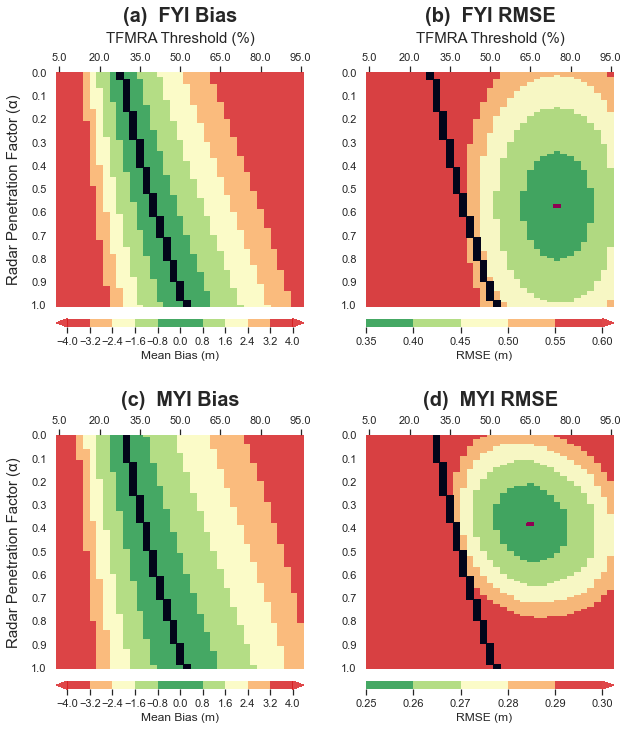

In [44]:
fig = plt.figure(figsize=(10,12))
spec = gridspec.GridSpec(ncols=2, nrows=2,wspace=0.25,hspace=0.25)
plt.rc('font', size=10)
plt.rcParams.update({'hatch.color': 'black'})
sns.set(rc={'axes.facecolor':'#f0f0f0'})
r_ticks = [[0.35,0.4,0.45,0.5,0.55,0.6],[0.25,0.26,0.27,0.28,0.29,0.3]]
slope_ticks = [[5,6,7,8,9,10],[2,2.5,3,3.5,4,4.5]]
nums = ['(a) ','(b) ','(c) ','(d) ','(e) ','(f) ']


k = 0
for icetype,limit_r,limit_slope,r_tick,slope_tick in zip(['FYI','MYI'],[[0.35,0.6],[0.25,0.3]],[[5,10],
    [2,4.5]],r_ticks,slope_ticks):

    ### bias heatmap
    bias_df = pd.DataFrame(biases_dict[icetype].T,columns=thresholds,index=alphas)
    ax1 = fig.add_subplot(spec[k])
    list_colors = ['#d7191c','#fdae61','#ffffbf','#a6d96a','#1a9641','#1a9641','#a6d96a','#ffffbf','#fdae61','#d7191c']
    cm = LinearSegmentedColormap.from_list('map', list_colors, N = 10)
    ticks = [-4,-3.2,-2.4,-1.6,-0.8,0,0.8,1.6,2.4,3.2,4]
    label = 'Mean Bias (m)'
    ax1 = sns.heatmap(bias_df, cmap=cm, annot=False, vmin=-4,vmax=4,yticklabels=10,cbar=True,alpha=0.8,
                      xticklabels=6,cbar_kws={'location': 'bottom','extend': 'both',"ticks":ticks,"aspect":30,"label":label,"pad": 0.04})
    ax1.tick_params(axis='y', labelrotation=0)
    ax1.set_ylabel('Radar Penetration Factor (\u03B1)',labelpad=10,fontsize=15)
    if k < 2:
        ax1.set_xlabel('TFMRA Threshold (%)',labelpad=10,fontsize=15)
    ax1.xaxis.tick_top()
    ax1.xaxis.set_label_position('top')
    ax1.set_title(f'{nums[k]} {icetype} Bias',fontweight='bold',fontsize=20,pad=10)
    
    ### calculate mins line
      
    mins = np.full((biases_dict[icetype].T.shape),np.nan) 

    for alpha in np.arange(0,len(mins)):
        min = np.nanargmin(np.abs(biases_dict[icetype][:,alpha]))
        mins[alpha,min] = 1
        
    x = np.arange(0,len(thresholds)+1)
    y = np.arange(0,len(alphas)+1)
    
    ax1.pcolor(x, y, mins)

    k+=1
    
    ### correlation 

    rs_df = pd.DataFrame(r_values_dict[icetype].T,columns=thresholds,index=alphas)
    ax2 = fig.add_subplot(spec[k])
    list_colors = ['#1a9641','#a6d96a','#ffffbf','#fdae61','#d7191c'] 
    cm = LinearSegmentedColormap.from_list('map', list_colors, N = 5)
    list_colors_mask = ['gainsboro','gainsboro'] 
    cm_mask = LinearSegmentedColormap.from_list('map', list_colors_mask, N = 2)
    mask = r_values_dict[icetype].T.copy()
    mask[np.isnan(mask)] = 1000
    mask[mask<1000] = 0
    label = 'RMSE (m)'
    ax2 = sns.heatmap(rs_df, cmap=cm_mask, annot=False, annot_kws={'color': 'k'},fmt=".2f", 
                      xticklabels=10,cbar=False,)
    
    ax2 = sns.heatmap(rs_df, cmap=cm, mask=mask,annot=False, linewidths=0,cbar=True, alpha=0.8,vmin=limit_r[0],
                      vmax=limit_r[1],yticklabels=10,xticklabels=6,cbar_kws={'location': 'bottom','extend': 'max',
                      "aspect":30,"label":label,"ticks":r_tick,"pad": 0.04})

    ### plot min line
    ax2.pcolor(x, y, mins)
    
    ax2.tick_params(axis='y', labelrotation=0)
    if k < 3:
        ax2.set_xlabel('TFMRA Threshold (%)',labelpad=10,fontsize=15)

    ### calculate lowest rmse
    min = r_values_dict[icetype].T.copy()
    mi = np.nanmin(r_values_dict[icetype])
    min[min>mi] = np.nan
    min[min==mi] = 1
    
    ax2.pcolor(x, y, min,cmap='PiYG')
    
    ax2.xaxis.tick_top()
    ax2.xaxis.set_label_position('top')
    ax2.set_title(f'{nums[k]} {icetype} RMSE',fontweight='bold',fontsize=20,pad=10)

    k+=1
    
plt.savefig('/Users/carmennab/Dropbox/Apps/Overleaf/Alpha Retracker/main_figs/bias_corr_icetype.jpg',
            bbox_inches = "tight", dpi = 400)

In [45]:
for data in ['FYI','MYI']:
    mins = []
    for alpha in np.arange(0,101):
        min = np.nanmin(np.abs(slope_dict[data][:,alpha]))
        mins.append(min)
    print(np.nanmin(mins),np.nanmax(mins))

5.319141908020133 10.146070560789182
2.406890002614889 6.116021161338077
